In [1]:
using JuMP, Cbc, Clp, Random, Statistics, Plots

In [2]:
N = collect(50:50:1000)
K = collect(100:100:1000)
M = 10

10

Confidence Interval for Ni=50: [-1367.4531398849695,-1280.4268601150316]
Confidence Interval for Ni=100: [-1358.763660983273,-1293.7563390167265]
Confidence Interval for Ni=150: [-1349.470558638328,-1280.2894413616718]
Confidence Interval for Ni=200: [-1328.3251172962648,-1303.3748827037355]
Confidence Interval for Ni=250: [-1330.080022380611,-1279.735977619389]
Confidence Interval for Ni=300: [-1331.837060599021,-1298.9762727343116]
Confidence Interval for Ni=350: [-1336.2424486991144,-1299.9575513008858]
Confidence Interval for Ni=400: [-1334.2293912861937,-1307.5606087138062]
Confidence Interval for Ni=450: [-1337.5619104761267,-1303.8114228572058]
Confidence Interval for Ni=500: [-1341.6734345515927,-1312.6385654484045]
Confidence Interval for Ni=550: [-1336.8255828707759,-1311.5271444019493]
Confidence Interval for Ni=600: [-1326.7861770218499,-1305.147156311483]
Confidence Interval for Ni=650: [-1319.8081536238244,-1305.7795386838563]
Confidence Interval for Ni=700: [-1318.828526

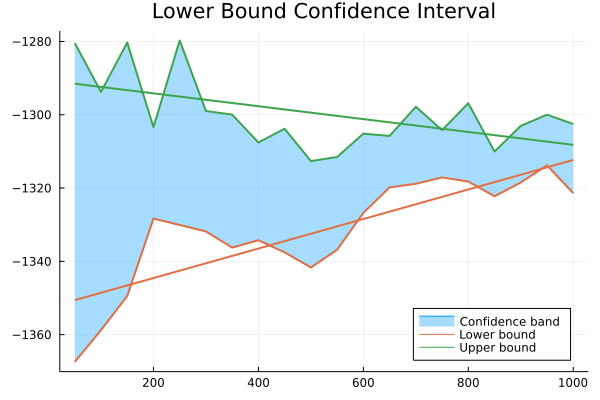


(process:9096): GLib-GIO-WARNING **: 22:45:05.914: Unexpectedly, UWP app `38526MediaLife.ZipPlus_2.0.4.0_x86__1crh1k73ty8mg' (AUMId `38526MediaLife.ZipPlus_1crh1k73ty8mg!ZipExtractor') supports 89 extensions but has no verbs


In [3]:
LB_left_Dict = Dict{Int, Float64}();
LB_right_Dict = Dict{Int, Float64}();
x_Dict =  Dict{Int, Vector{Float64}}();
for Ni in N    
    obj_value_list = []
    x_list = []
    for i=1:M    
        ξ = rand(50:150,Ni)
        master = Model(Clp.Optimizer)
        set_optimizer_attribute(master, "LogLevel",0)
        @variables(master,begin
            x ≥ 0
            y[1:Ni] ≥ 0
            w[1:Ni] ≥ 0
        end)
        @constraints(master,begin
            ct1[s=1:Ni], y[s] ≤ ξ[s]
            ct2[s=1:Ni], y[s] + w[s] ≤ x
        end)
        @objective(master, Min, 10*x + (1/Ni)*sum(-25*y[s] - 5*w[s] for s in 1:Ni))
        optimize!(master)
        append!(x_list,value(x))
        append!(obj_value_list, objective_value(master))
    end

    V̄=sum(obj_value_list)/M
    LB_left = V̄ - 1.96*std(obj_value_list)/sqrt(M)
    LB_right = V̄ + 1.96*std(obj_value_list)/sqrt(M)
    push!(LB_left_Dict,Ni =>LB_left)
    push!(LB_right_Dict,Ni =>LB_right)
    push!(x_Dict, Ni => x_list)
    println("Confidence Interval for Ni=$(Ni): [$(LB_left),$(LB_right)]")
end
# println(sort(x_Dict))
# println(LB_left_Dict)
# println(LB_right_Dict)

u = x-> LB_right_Dict[x]
plot(x=N,LB_left_Dict, fillrange=u,fillalpha = 0.35,label = "Confidence band", legend = :bottomright, title = "Lower Bound Confidence Interval")
plot!(x=N,LB_left_Dict, smooth=true, label = "Lower bound",lw = 2)
plot!(x=N,LB_right_Dict, smooth=true, label = "Upper bound",lw = 2)

In [4]:
obj_value_list = []
UB_left_Dict = Dict{Float64, Float64}();
UB_right_Dict = Dict{Float64, Float64}();
for x̂ in x_Dict[1000]
    Ki=1000
    for i=1:M    
        ξ = rand(50:150,Ki)
        UB_model = Model(Clp.Optimizer)
        set_optimizer_attribute(UB_model, "LogLevel",0)
        @variables(UB_model,begin
            y[1:Ki] ≥ 0
            w[1:Ki] ≥ 0
        end)
        @constraints(UB_model,begin
            ct1[s=1:Ki], y[s] ≤ ξ[s]
            ct2[s=1:Ki], y[s] + w[s] ≤ x̂
        end)
        @objective(UB_model, Min, 10*x̂ + (1/Ki)*sum(-25*y[s] - 5*w[s] for s in 1:Ki))
        optimize!(UB_model)
        append!(obj_value_list, objective_value(UB_model))
    end
    V̄=sum(obj_value_list)/M
    
    UB_left = V̄ - 1.96*std(obj_value_list)/sqrt(M)
    UB_right = V̄ + 1.96*std(obj_value_list)/sqrt(M)
    push!(UB_left_Dict,x̂ =>UB_left)
    push!(UB_right_Dict,x̂ =>UB_right)
    println("Confidence Interval for x̂=$(x̂): [$(UB_left),$(UB_right)]")
end

x_chosen = reduce((x, y) -> UB_right_Dict[x] ≤ UB_right_Dict[y] ? x : y, keys(UB_right_Dict)) # x̂ que gera a menor entre as M cotas superiores

println(x_chosen)
# println(UB_right_Dict)

Confidence Interval for x̂=124.00000000000199: [-1316.1695465052574,-1300.4864534947621]
Confidence Interval for x̂=127.0: [-2633.0377339300994,-2617.3422660699216]
Confidence Interval for x̂=126.00000000000895: [-3942.452809768232,-3924.3151902317745]
Confidence Interval for x̂=123.00000000000597: [-5250.02080778315,-5229.9071922168605]
Confidence Interval for x̂=124.00000000000597: [-6567.878433441607,-6549.165566558428]
Confidence Interval for x̂=127.00000000000398: [-7882.410005688953,-7864.021994311106]
Confidence Interval for x̂=122.00000000000796: [-9188.593790960158,-9169.930209039898]
Confidence Interval for x̂=122.00000000000796: [-10491.375000580683,-10473.08099941937]
Confidence Interval for x̂=124.00000000001293: [-11797.661093242208,-11779.618906757878]
Confidence Interval for x̂=125.00000000000199: [-13117.582968247953,-13098.325031752123]
125.00000000000199


Confidence Interval for Ki=100: [-1351.3390314629444,-1294.1809685370533]
Confidence Interval for Ki=200: [-1339.33601937447,-1290.523980625543]
Confidence Interval for Ki=300: [-1331.1799854633764,-1295.8200145366222]
Confidence Interval for Ki=400: [-1340.661475537357,-1289.3885244626313]
Confidence Interval for Ki=500: [-1325.4412019898211,-1298.1267980101668]
Confidence Interval for Ki=600: [-1320.2717109652115,-1299.5282890348078]
Confidence Interval for Ki=700: [-1316.236724563582,-1300.0318468649798]
Confidence Interval for Ki=800: [-1324.7663130352212,-1303.1986869647526]
Confidence Interval for Ki=900: [-1312.0688704317581,-1295.0111295682095]
Confidence Interval for Ki=1000: [-1317.062719274853,-1299.2932807251336]


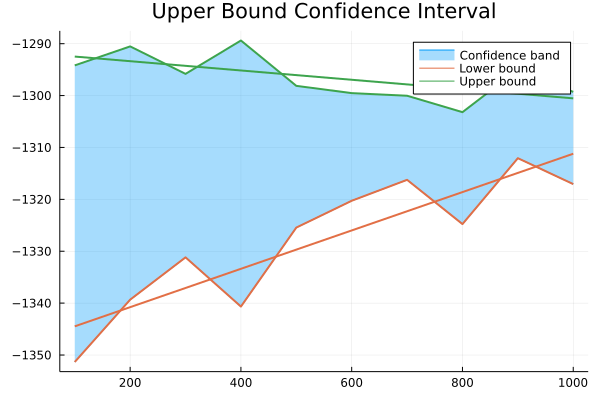

In [5]:
UB_left_Dict = Dict{Float64, Float64}();
UB_right_Dict = Dict{Float64, Float64}();

for Ki in K
    obj_value_list = []
    for i=1:M    
        ξ = rand(50:150,Ki)
        UB_model = Model(Clp.Optimizer)
        set_optimizer_attribute(UB_model, "LogLevel",0)
        @variables(UB_model,begin
            y[1:Ki] ≥ 0
            w[1:Ki] ≥ 0
        end)
        @constraints(UB_model,begin
            ct1[s=1:Ki], y[s] ≤ ξ[s]
            ct2[s=1:Ki], y[s] + w[s] ≤ x_chosen
        end)
        @objective(UB_model, Min, 10*x_chosen + (1/Ki)*sum(-25*y[s] - 5*w[s] for s in 1:Ki))
        optimize!(UB_model)
        append!(obj_value_list, objective_value(UB_model))
    end
    V̄=sum(obj_value_list)/M
    UB_left = V̄ - 1.96*std(obj_value_list)/sqrt(M)
    UB_right = V̄ + 1.96*std(obj_value_list)/sqrt(M)
    push!(UB_left_Dict,Ki =>UB_left)
    push!(UB_right_Dict,Ki =>UB_right)
    println("Confidence Interval for Ki=$(Ki): [$(UB_left),$(UB_right)]")

end

u = x-> UB_right_Dict[x]
plot(x=N,UB_left_Dict, fillrange=u,fillalpha = 0.35,label = "Confidence band", legend = :topright, title = "Upper Bound Confidence Interval")
plot!(x=N,UB_left_Dict, smooth=true, label = "Lower bound",lw = 2)
plot!(x=N,UB_right_Dict, smooth=true, label = "Upper bound",lw = 2)

In [6]:
function Q(x,ξ)
    m = Model(Clp.Optimizer)
    set_optimizer_attribute(m, "LogLevel",0)
    @variables(m, 
    begin
        y ≥ 0
        w ≥ 0
    end)

    @constraints(m,
    begin
        y ≤ ξ
        aux, y + w ≤ x
    end)

    @objective(m, Min, -25 * y - 5 * w)
    optimize!(m)
    return objective_value(m)
end

Q (generic function with 1 method)

In [7]:
Gj_value_list = []
UB_left_Dict = Dict{Float64, Float64}();
UB_right_Dict = Dict{Float64, Float64}();
for x̂ in x_Dict[1000]
    Ni=1000
    for i=1:M    
        ξ = rand(50:150,Ni)
        GAP_part1 = 10*x̂ + (1/Ni)*sum(Q(x̂,ξ[s]) for s in 1:Ni)
        
        GAP_model = Model(Clp.Optimizer)
        set_optimizer_attribute(GAP_model, "LogLevel",0)
        @variables(GAP_model,begin
            x >= 0
            y[1:Ni] ≥ 0
            w[1:Ni] ≥ 0
        end)
        @constraints(GAP_model,begin
            ct1[s=1:Ni], y[s] ≤ ξ[s]
            ct2[s=1:Ni], y[s] + w[s] ≤ x
        end)
        @objective(GAP_model, Min, 10*x + (1/Ni)*sum(-25*y[s] - 5*w[s] for s in 1:Ni))
        optimize!(GAP_model)
        
        GAP_part2 = objective_value(GAP_model)
        
        append!(Gj_value_list, GAP_part1 - GAP_part2)
    end
    Ḡ =sum(Gj_value_list)/M
    UB_left = Ḡ - 1.96*std(Gj_value_list)/sqrt(M)
    UB_right = Ḡ + 1.96*std(Gj_value_list)/sqrt(M)
    push!(UB_right_Dict,x̂ =>UB_right)
    push!(UB_left_Dict,x̂ =>UB_left)
    println("Confidence Interval for x̂=$(x̂): [$(UB_left),$(UB_right)]")
end

x_chosen = reduce((x, y) -> UB_right_Dict[x] ≤ UB_right_Dict[y] ? x : y, keys(UB_right_Dict)) # x̂ que gera a menor entre as M cotas superiores

println(x_chosen)


Confidence Interval for x̂=124.00000000000199: [0.17260906558502975,0.37539093459637074]
Confidence Interval for x̂=127.0: [0.4707160151149608,0.8412839852109457]
Confidence Interval for x̂=126.00000000000895: [0.7968801009247072,1.179119899617783]
Confidence Interval for x̂=123.00000000000597: [1.4221978822737888,2.0418021184381963]
Confidence Interval for x̂=124.00000000000597: [1.6501808105365672,2.225819190351803]
Confidence Interval for x̂=127.00000000000398: [2.0820100967611266,2.6539899043279602]
Confidence Interval for x̂=122.00000000000796: [3.1820748948495607,3.961925106433969]
Confidence Interval for x̂=122.00000000000796: [4.589610121434627,5.53438988003514]
Confidence Interval for x̂=124.00000000001293: [4.819260067137737,5.728739934530459]
Confidence Interval for x̂=125.00000000000199: [4.993009781523768,5.870990220322629]
124.00000000000199
